### Importing required libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
from sklearn.neural_network import MLPClassifier
from collections import Counter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv(r'/content/drive/MyDrive/auto_insurance_dataset/train.csv')

### Viewing Dataset

In [ ]:
data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [ ]:
data.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.551102,8.295933,0.829948,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674,2.346072,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.793506,2.508270,0.375679,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455,0.832548,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.720677,7.000000,1.000000,-1.000000,0.000000,0.000000,7.00000

### Exploratory Data Analysis

**Insight 1**: This is a high dimensional data with 59 columns. So, to tackle model building part, PCA would be used. Directly usage of high no. of columns would lead to increase in execution time of models and would lead to overfitting of data.

In [ ]:
claims_dict = dict(data['target'].value_counts())
claims_total = sum(list(claims_dict.values()))
for key in claims_dict:
    claims_dict[key] = claims_dict[key]*100/claims_total
print('% of claims accepted:',claims_dict[0])
print('% of claims rejected:',claims_dict[1])

% of claims accepted: 96.35524821408171
% of claims rejected: 3.6447517859182947


**Insight 2**: The target for prediction in the data here is highly skewed towards claims being rejected by the insurance company (about 96%) and merely 4% of claims are accepted. 

In [ ]:
new_data = data.replace(to_replace=-1,value=np.nan)
data_len = len(new_data)
null_percent_dict = dict(new_data.isnull().sum())
for i in null_percent_dict:
    null_percent_dict[i] = null_percent_dict[i]*100/len(new_data)

In [ ]:
null_percent_dict

{'id': 0.0,
 'ps_calc_01': 0.0,
 'ps_calc_02': 0.0,
 'ps_calc_03': 0.0,
 'ps_calc_04': 0.0,
 'ps_calc_05': 0.0,
 'ps_calc_06': 0.0,
 'ps_calc_07': 0.0,
 'ps_calc_08': 0.0,
 'ps_calc_09': 0.0,
 'ps_calc_10': 0.0,
 'ps_calc_11': 0.0,
 'ps_calc_12': 0.0,
 'ps_calc_13': 0.0,
 'ps_calc_14': 0.0,
 'ps_calc_15_bin': 0.0,
 'ps_calc_16_bin': 0.0,
 'ps_calc_17_bin': 0.0,
 'ps_calc_18_bin': 0.0,
 'ps_calc_19_bin': 0.0,
 'ps_calc_20_bin': 0.0,
 'ps_car_01_cat': 0.01797678810239041,
 'ps_car_02_cat': 0.0,
 'ps_car_03_cat': 69.08983689844963,
 'ps_car_04_cat': 0.0,
 'ps_car_05_cat': 44.78253126617071,
 'ps_car_06_cat': 0.0,
 'ps_car_07_cat': 1.9302366215734899,
 'ps_car_08_cat': 0.0,
 'ps_car_09_cat': 0.09559619093701067,
 'ps_car_10_cat': 0.0,
 'ps_car_11': 0.0008400368272145051,
 'ps_car_11_cat': 0.0,
 'ps_car_12': 0.000168007365442901,
 'ps_car_13': 0.0,
 'ps_car_14': 7.160473915176441,
 'ps_car_15': 0.0,
 'ps_ind_01': 0.0,
 'ps_ind_02_cat': 0.03628959093566662,
 'ps_ind_03': 0.0,
 'ps_ind_04_cat

**Insight 3**: Only 12 columns out of 59 columns have missing values in the data, out of which *ps_car_03_cat* has more than 50% of data missing and remaining features possess less than 50% missing data, which can be useful in futher analysis. 

In [ ]:
col_list = list(data.columns)
var_count_dict = dict.fromkeys(['binary_var_count','categorical_var_count','continuous/ordinal_var_count'],0)
continuous_ordinal_var = []
binary_var = []
categorical_var = []
for i in col_list:
    last_3 = i[-3:]
    if last_3=='bin' or i=='target':
        var_count_dict['binary_var_count']+=1
        binary_var.append(i)
    elif last_3=='cat':
        var_count_dict['categorical_var_count']+=1
        categorical_var.append(i)
    else:
        var_count_dict['continuous/ordinal_var_count']+=1
        continuous_ordinal_var.append(i)
print(var_count_dict)

{'binary_var_count': 18, 'categorical_var_count': 14, 'continuous/ordinal_var_count': 27}


As we can see from above, there are 18 binary features, 14 categorical features and 27 continuous/ordinal features.

#### Inferences from data on interval, binary and ordinal variables.

In [ ]:
interval_var = []
ordinal_var = []
for i in continuous_ordinal_var:
    if data[i].dtype=='float':
        interval_var.append(i)
    else:
        if i!='id':
            ordinal_var.append(i)

In [ ]:
print('Ordinal variables:',ordinal_var)
print('\n')
print('Interval variables:',interval_var)
print('\n')
print('Binary variables:',binary_var)

Ordinal variables: ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_car_11', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']


Interval variables: ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03']


Binary variables: ['target', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']


In [ ]:
data[ordinal_var].head()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
0,2,5,0,11,2,3,1,10,1,10,1,5,9,1,5,8
1,1,7,0,3,3,2,1,9,5,8,1,7,3,1,1,9
2,5,9,0,12,1,2,2,9,1,8,2,7,4,2,7,7
3,0,2,0,8,1,2,4,7,1,8,4,2,2,2,4,9
4,0,0,0,9,3,2,2,6,3,10,2,12,3,1,1,3


In [ ]:
data[interval_var].head()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
0,0.7,0.2,0.718070,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2
1,0.8,0.4,0.766078,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3
2,0.0,0.0,-1.000000,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1
3,0.9,0.2,0.580948,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1
4,0.7,0.6,0.840759,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0


In [ ]:
data[binary_var].head()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1
1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0
2,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0
3,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0


#### **Insight 1:**
* Ordinal variables here are sort of one-hot encoded features here, which is integral in nature ranging from 0 to some integer n.
* Interval variables appear to be of type float.
* Binary are the ones that only take boolean values. 

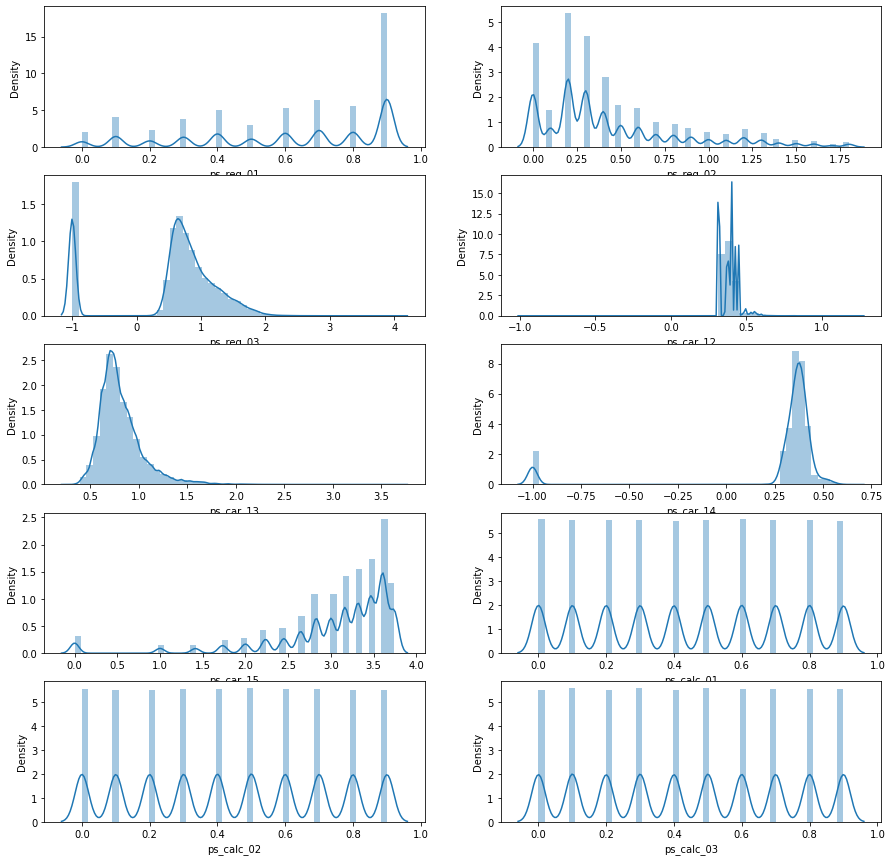

In [ ]:
#Frequency Distribution plot for Interval variables
count=1
plt.figure(figsize=(15,15))
for i in interval_var:
    plt.subplot(5,2,count)
    sns.distplot(data[i])
    count+=1

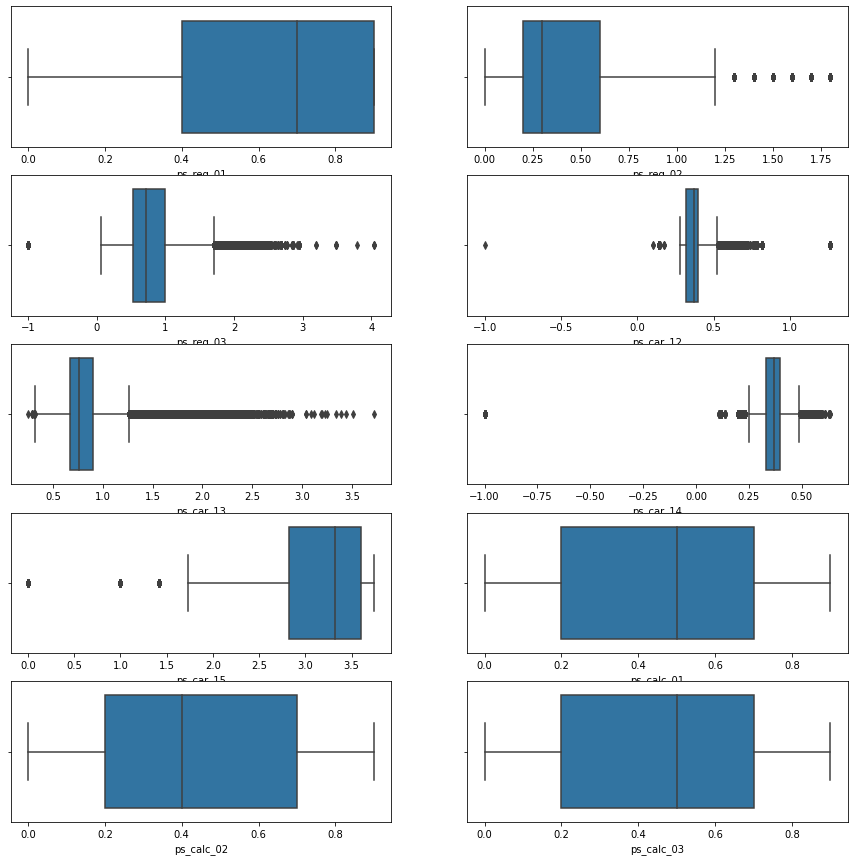

In [ ]:
#Boxplot for Interval variables.
count=1
plt.figure(figsize=(15,15))
for i in interval_var:
    plt.subplot(5,2,count)
    sns.boxplot(data[i])
    count+=1

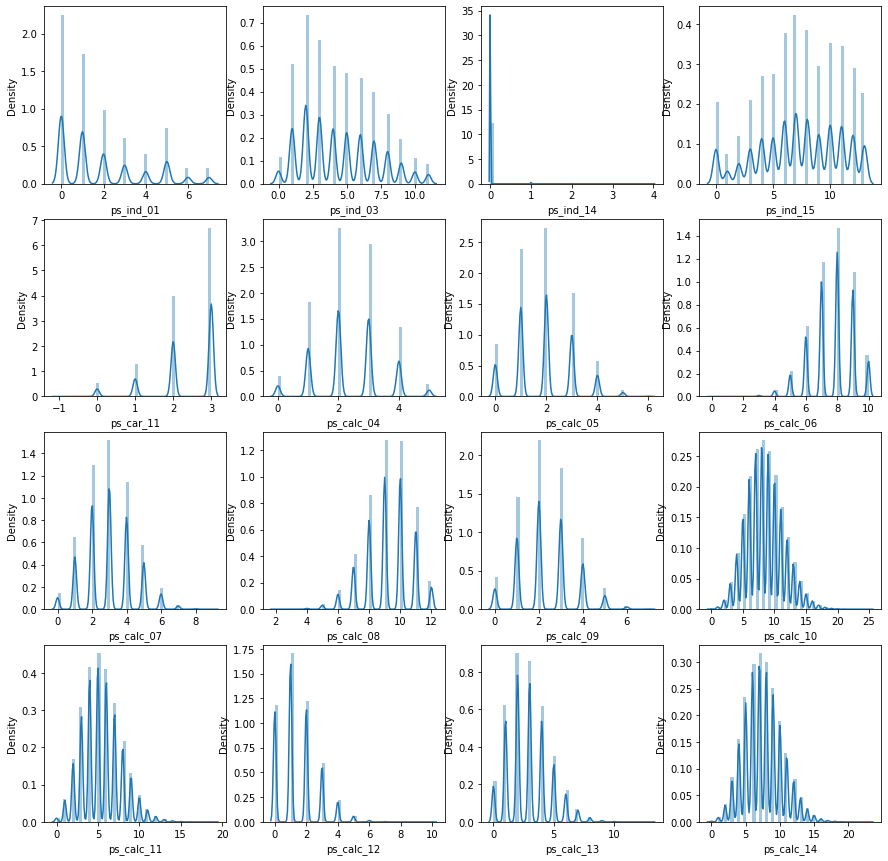

In [ ]:
#Frequency Distribution plot for Ordinal variables
count=1
plt.figure(figsize=(15,15))
for i in ordinal_var:
    plt.subplot(4,4,count)
    sns.distplot(data[i])
    count+=1

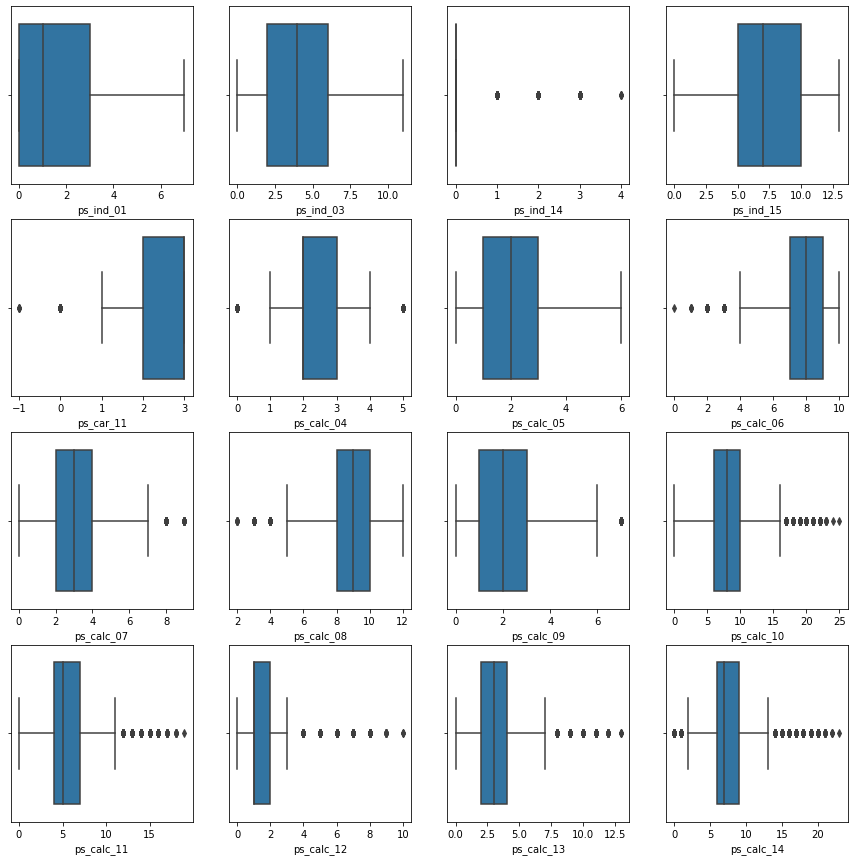

In [ ]:
#Boxplot for Ordinal variables.
count=1
plt.figure(figsize=(15,15))
for i in ordinal_var:
    plt.subplot(4,4,count)
    sns.boxplot(data[i])
    count+=1

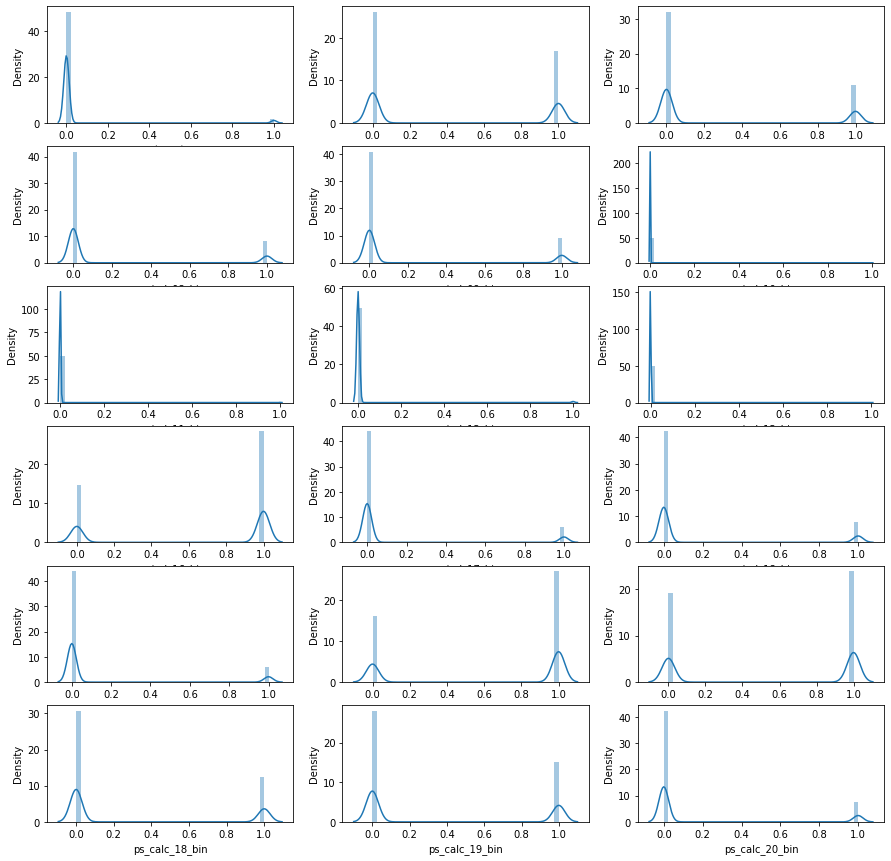

In [ ]:
#Frequency Distribution plot for Binary variables
count=1
plt.figure(figsize=(15,15))
for i in binary_var:
    plt.subplot(6,3,count)
    sns.distplot(data[i])
    count+=1

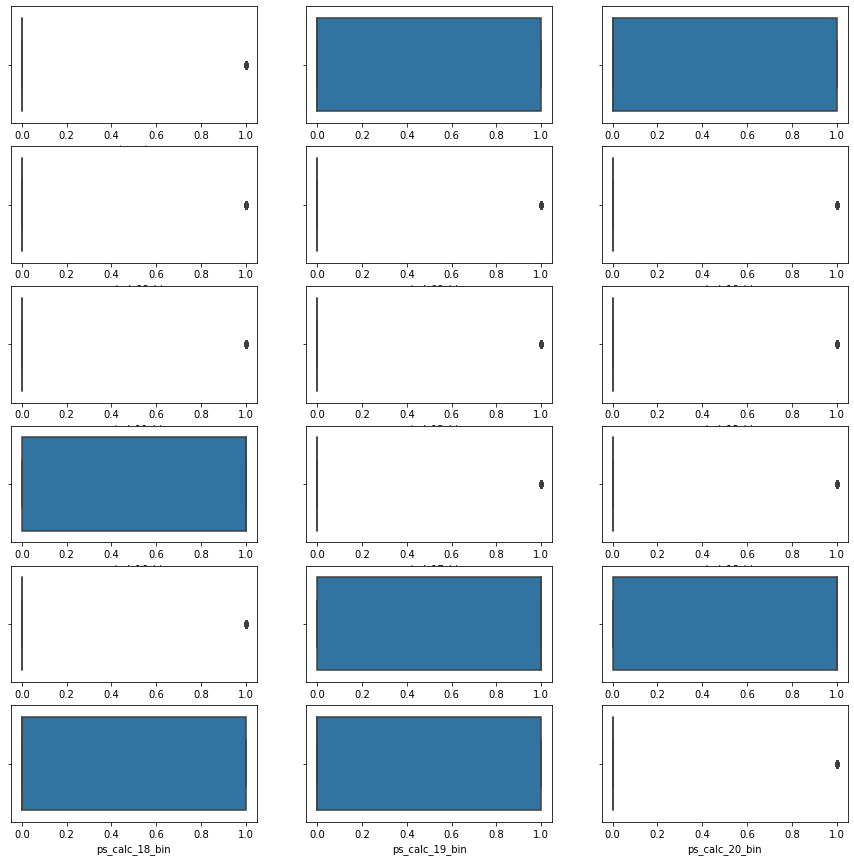

In [ ]:
#Boxplot for Binary variables
count=1
plt.figure(figsize=(15,15))
for i in binary_var:
    plt.subplot(6,3,count)
    sns.boxplot(data[i])
    count+=1

**Insight 2:**
* In interval variables, *ps_reg_02*, *ps_reg_03*, *ps_car_12*, *ps_car_13*,*ps_car_14* and *ps_car_15* have outliers present in them, while remaining are outlier-free. Also, these are the variables that have skewed frequency distribution curve due to the presence of outliers.
* In ordinal variables, except 4 variables, namely, *ps_ind_14*, *ps_ind_03*, *ps_ind_15*, *ps_calc_05* all the remaining ordinal variable have atleast one outliers. Hence, we can observe slight skewness in them from the frequency distribution curve.
* In binary variables, since we only have two values (0 and 1), outlier analysis doesn't make much sense.

A the data is highly imbalanced, We will use SMOTE(Synthetic Minority Oversampling Technique) to balance the data.SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

#### Number of features having missing values

In [ ]:
count = 0
non_null_features = []
for i in null_percent_dict:
    if null_percent_dict[i]!=0:
        count+=1
        non_null_features.append(i)
print('No. of features having missing values:',count)

No. of features having missing values: 12


We will be filling missing values with the median value of the respective non-null features because as we saw earlier many 
features have outliers, so filling with mean value is sub-optimal.

In [ ]:
non_null_features

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_reg_03',
 'ps_car_01_cat',
 'ps_car_03_cat',
 'ps_car_05_cat',
 'ps_car_07_cat',
 'ps_car_09_cat',
 'ps_car_11',
 'ps_car_12',
 'ps_car_14']

In [ ]:
for i in non_null_features:
    new_data[i] = new_data.fillna(new_data[i].median())[i]

In [ ]:
new_data.isnull().sum()

id                0
target            0
ps_ind_01         0
ps_ind_02_cat     0
ps_ind_03         0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14         0
ps_ind_15         0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01         0
ps_reg_02         0
ps_reg_03         0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_03_cat     0
ps_car_04_cat     0
ps_car_05_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        0
ps_calc_07        0
ps_calc_08        0
ps_calc_09        0
ps_calc_10        0
ps_calc_11        0


#### Interval variables having strong correlation?  

In [ ]:
interval_corr_matrix = new_data[interval_var].corr()
target_corr_matrix = new_data[interval_var+['target']].corr().sort_values(by='target',ascending=False)['target']
target_corr_matrix

target        1.000000
ps_car_13     0.053899
ps_car_12     0.038800
ps_reg_02     0.034800
ps_reg_03     0.033344
ps_car_15     0.027667
ps_reg_01     0.022888
ps_car_14     0.011161
ps_calc_03    0.001907
ps_calc_01    0.001782
ps_calc_02    0.001360
Name: target, dtype: float64

In [ ]:
interval_corr_matrix

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
ps_reg_01,1.000000,0.471027,0.206868,0.018782,0.027097,-0.001912,0.002765,-0.000891,0.002194,-0.001538
ps_reg_02,0.471027,1.000000,0.728096,0.171453,0.194316,0.053362,0.054510,0.001347,-0.000770,0.000022
ps_reg_03,0.206868,0.728096,1.000000,0.203473,0.238886,0.075862,0.080780,0.000532,-0.000176,0.001517
ps_car_12,0.018782,0.171453,0.203473,1.000000,0.672014,0.577044,0.049740,-0.000721,-0.000393,0.000151
ps_car_13,0.027097,0.194316,0.238886,0.672014,1.000000,0.433587,0.529519,0.000157,0.000040,-0.000200
ps_car_14,-0.001912,0.053362,0.075862,0.577044,0.433587,1.000000,0.008842,-0.003159,-0.001804,-0.001065
ps_car_15,0.002765,0.054510,0.080780,0.049740,0.529519,0.008842,1.000000,0.000344,-0.000252,-0.001043
ps_calc_01,-0.000891,0.001347,0.000532,-0.000721,0.000157,-0.003159,0.000344,1.000000,-0.002418,0.000526
ps_calc_02,0.002194,-0.000770,-0.000176,-0.000393,0.000040,-0.001804,-0.000252,-0.002418,1.000000,0.002948
ps_calc_03,-0.001538,0.000022,0.001517,0.000151,-0.000200,-0.001065,-0.001043,0.000526,0.002948,1.000000


* *ps_car_13*, *ps_car_12* and *ps_reg_02* are the top 3 features that exhibit strong correlation with the target variable.
* In terms of correlation amongst interval features themselves *(ps_reg_02, ps_reg_03)* exhibit highest correlation, *(ps_car_12, ps_car_13, ps_car_14, ps_car_15)* and *(ps_reg_01, ps_reg_02)* exhibit medium level correlation.

#### Level of correlation among ordinal features 

In [ ]:
ordinal_corr_matrix = new_data[ordinal_var].corr()
ordinal_corr_matrix

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
ps_ind_01,1.000000,0.223408,-0.024971,0.122137,0.008262,-9.430788e-04,-0.001171,0.000147,-0.000658,0.002993,-0.000085,-1.344982e-03,-0.001263,0.001521,0.000199,-0.000891
ps_ind_03,0.223408,1.000000,0.001990,0.170449,-0.059335,7.029223e-04,-0.001245,0.002361,0.001533,0.001267,-0.001544,2.302873e-04,-0.002716,-0.002352,0.000133,0.000205
ps_ind_14,-0.024971,0.001990,1.000000,-0.121547,0.004415,-1.102298e-03,0.000205,-0.000242,0.001023,0.004077,-0.001443,1.975748e-03,-0.000243,0.000284,0.000307,-0.000387
ps_ind_15,0.122137,0.170449,-0.121547,1.000000,0.023041,1.583613e-03,0.000874,0.000033,0.001721,-0.001309,-0.000985,-1.278706e-03,-0.001952,-0.001263,-0.000922,0.001348
ps_car_11,0.008262,-0.059335,0.004415,0.023041,1.000000,2.404439e-04,0.002456,-0.000242,-0.000330,-0.002432,-0.000476,-5.816562e-04,-0.001190,-0.001203,0.001160,0.000931
ps_calc_04,-0.000943,0.000703,-0.001102,0.001584,0.000240,1.000000e+00,0.000633,-0.001845,0.001445,-0.001847,-0.000038,5.835325e-08,0.000245,0.000978,-0.000215,0.001180
ps_calc_05,-0.001171,-0.001245,0.000205,0.000874,0.002456,6.326671e-04,1.000000,-0.001394,-0.002212,-0.001792,0.001154,-2.358151e-04,0.000387,-0.000212,0.000270,-0.000969
ps_calc_06,0.000147,0.002361,-0.000242,0.000033,-0.000242,-1.845321e-03,-0.001394,1.000000,-0.000075,-0.000603,0.001710,-1.534410e-03,-0.000575,0.000607,0.000974,-0.000870
ps_calc_07,-0.000658,0.001533,0.001023,0.001721,-0.000330,1.445124e-03,-0.002212,-0.000075,1.000000,-0.002085,0.000756,-5.302752e-04,-0.000109,-0.000389,-0.000599,0.001908
ps_calc_08,0.002993,0.001267,0.004077,-0.001309,-0.002432,-1.846555e-03,-0.001792,-0.000603,-0.002085,1.000000,0.000013,-2.665669e-03,0.002016,0.000109,-0.000304,-0.000171


It appears that ordinal features in general are exhibiting very weak correlation among themselves.

#### Implementing Hot Encoding for categorical features

In [ ]:
categorical_var

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [ ]:
one_hot_encoded_df_list = []
for i in categorical_var:
    one_hot_encoded_df_list.append(pd.get_dummies(new_data[i],prefix=i))
one_hot_encoded_df = pd.concat(one_hot_encoded_df_list,axis=1)

In [ ]:
one_hot_encoded_df.head()

,ps_ind_02_cat_1.0,ps_ind_02_cat_2.0,ps_ind_02_cat_3.0,ps_ind_02_cat_4.0,ps_ind_04_cat_0.0,ps_ind_04_cat_1.0,ps_ind_05_cat_0.0,ps_ind_05_cat_1.0,ps_ind_05_cat_2.0,ps_ind_05_cat_3.0,ps_ind_05_cat_4.0,ps_ind_05_cat_5.0,ps_ind_05_cat_6.0,ps_car_01_cat_0.0,ps_car_01_cat_1.0,ps_car_01_cat_2.0,ps_car_01_cat_3.0,ps_car_01_cat_4.0,ps_car_01_cat_5.0,ps_car_01_cat_6.0,ps_car_01_cat_7.0,ps_car_01_cat_8.0,ps_car_01_cat_9.0,ps_car_01_cat_10.0,ps_car_01_cat_11.0,ps_car_02_cat_0,ps_car_02_cat_1,ps_car_03_cat_0.0,ps_car_03_cat_1.0,ps_car_04_cat_0,ps_car_04_cat_1,ps_car_04_cat_2,ps_car_04_cat_3,ps_car_04_cat_4,ps_car_04_cat_5,ps_car_04_cat_6,ps_car_04_cat_7,ps_car_04_cat_8,ps_car_04_cat_9,ps_car_05_cat_0.0,...,ps_car_11_cat_65,ps_car_11_cat_66,ps_car_11_cat_67,ps_car_11_cat_68,ps_car_11_cat_69,ps_car_11_cat_70,ps_car_11_cat_71,ps_car_11_cat_72,ps_car_11_cat_73,ps_car_11_cat_74,ps_car_11_cat_75,ps_car_11_cat_76,ps_car_11_cat_77,ps_car_11_cat_78,ps_car_11_cat_79,ps_car_11_cat_80,ps_car_11_cat_81,ps_car_11_cat_82,ps_car_11_cat_83,ps_car_11_cat_84,ps_car_11_cat_85,ps_car_11_cat_86,ps_car_11_cat_87,ps_car_11_cat_88,ps_car_11_cat_89,ps_car_11_cat_90,ps_car_11_cat_91,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Here, since categorical features are already one-hot encoded. We will treat ordinal features as nominal ones and check the suitability of StandardScaling for nominal and interval features. 

In [ ]:
nominal_interval_var = continuous_ordinal_var[1:]
new_data[nominal_interval_var]

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
0,2,5,0,11,0.7,0.2,0.718070,2.0,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8
1,1,7,0,3,0.8,0.4,0.766078,3.0,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9
2,5,9,0,12,0.0,0.0,0.801561,1.0,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7
3,0,2,0,8,0.9,0.2,0.580948,1.0,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9
4,0,0,0,9,0.7,0.6,0.840759,3.0,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,3,10,0,13,0.5,0.3,0.692820,3.0,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6
595208,5,3,0,6,0.9,0.7,1.382027,2.0,0.387298,0.972145,0.373497,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8
595209,1,10,0,12,0.9,0.2,0.659071,3.0,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6
595210,5,3,0,12,0.9,0.4,0.698212,3.0,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2


It appears that ordinal features are suitable for Standard Scaling since they have higher order of magnitude(about 10 times) than interval features.

In [ ]:
scaled_new_data = new_data.copy()
sc = StandardScaler()
scaled_new_data[ordinal_var] = sc.fit_transform(data[ordinal_var])

In [ ]:
scaled_new_data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,0.050218,2.0,0.213594,1.0,0.0,0,1,0,0,0,0,0,0,-0.097621,1.043440,0,1,0,0.7,0.2,0.718070,10.0,1,1.0,0,1.0,4,1.0,0,0.0,1,12,-0.415678,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,0.562038,-0.780567,1.731646,-1.417981,0.530322,-1.073849,-1.182124,1.525425,-0.367359,1.255372,0.167831,0,1,1,0,0,1
1,9,0,-0.453868,1.0,0.954362,0.0,0.0,0,0,1,0,0,0,0,0,-0.097621,-1.212598,0,0,1,0.8,0.4,0.766078,11.0,1,1.0,0,1.0,11,1.0,1,2.0,1,19,0.785455,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,-0.333042,-0.780567,0.982196,1.409748,-0.839850,-1.073849,-0.493559,-1.046515,-0.367359,-1.104669,0.531911,0,1,1,0,1,0
2,13,0,1.562477,4.0,1.695130,1.0,0.0,0,0,1,0,0,0,0,0,-0.097621,1.325445,1,0,0,0.0,0.0,0.801561,7.0,1,1.0,0,1.0,14,1.0,1,2.0,1,60,-1.616811,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,-0.333042,0.100547,0.982196,-1.417981,-0.839850,-0.271891,-0.493559,-0.617858,0.463923,2.435393,-0.196249,0,1,1,0,1,0
3,16,0,-0.957955,1.0,-0.897559,0.0,0.0,1,0,0,0,0,0,0,0,-0.097621,0.197425,1,0,0,0.9,0.2,0.580948,7.0,1,0.0,0,1.0,11,1.0,1,3.0,1,104,-1.616811,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,-0.333042,1.862777,-0.516705,-1.417981,-0.839850,1.332025,-2.214970,-1.475171,0.463923,0.665362,0.531911,0,0,0,0,0,0
4,17,0,-0.957955,2.0,-1.638327,1.0,0.0,1,0,0,0,0,0,0,0,-0.097621,0.479430,1,0,0,0.7,0.6,0.840759,11.0,1,1.0,0,1.0,14,1.0,1,2.0,1,82,0.785455,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,-0.333042,0.100547,-1.266155,-0.004117,0.530322,-0.271891,1.227851,-1.046515,-0.367359,-1.104669,-1.652569,0,0,0,1,1,0


We want minority classes(target 1) to be 12% of the majority classes(target 0). So, we will take sampling strategy to be 0.12.

In [ ]:
X = scaled_new_data.drop('target',axis=1)
Y = scaled_new_data['target']

In [ ]:
oversample = SMOTE(sampling_strategy = 0.12)
X, Y = oversample.fit_resample(X,Y)

In [ ]:
Counter(Y)

Counter({0: 573518, 1: 68822})

So, we see that after achieving a balance of 12%, total number of training records becomes 573518+68822 = 642340 records.

In [ ]:
one_hot_encoded_df

,ps_ind_02_cat_1.0,ps_ind_02_cat_2.0,ps_ind_02_cat_3.0,ps_ind_02_cat_4.0,ps_ind_04_cat_0.0,ps_ind_04_cat_1.0,ps_ind_05_cat_0.0,ps_ind_05_cat_1.0,ps_ind_05_cat_2.0,ps_ind_05_cat_3.0,ps_ind_05_cat_4.0,ps_ind_05_cat_5.0,ps_ind_05_cat_6.0,ps_car_01_cat_0.0,ps_car_01_cat_1.0,ps_car_01_cat_2.0,ps_car_01_cat_3.0,ps_car_01_cat_4.0,ps_car_01_cat_5.0,ps_car_01_cat_6.0,ps_car_01_cat_7.0,ps_car_01_cat_8.0,ps_car_01_cat_9.0,ps_car_01_cat_10.0,ps_car_01_cat_11.0,ps_car_02_cat_0,ps_car_02_cat_1,ps_car_03_cat_0.0,ps_car_03_cat_1.0,ps_car_04_cat_0,ps_car_04_cat_1,ps_car_04_cat_2,ps_car_04_cat_3,ps_car_04_cat_4,ps_car_04_cat_5,ps_car_04_cat_6,ps_car_04_cat_7,ps_car_04_cat_8,ps_car_04_cat_9,ps_car_05_cat_0.0,...,ps_car_11_cat_65,ps_car_11_cat_66,ps_car_11_cat_67,ps_car_11_cat_68,ps_car_11_cat_69,ps_car_11_cat_70,ps_car_11_cat_71,ps_car_11_cat_72,ps_car_11_cat_73,ps_car_11_cat_74,ps_car_11_cat_75,ps_car_11_cat_76,ps_car_11_cat_77,ps_car_11_cat_78,ps_car_11_cat_79,ps_car_11_cat_80,ps_car_11_cat_81,ps_car_11_cat_82,ps_car_11_cat_83,ps_car_11_cat_84,ps_car_11_cat_85,ps_car_11_cat_86,ps_car_11_cat_87,ps_car_11_cat_88,ps_car_11_cat_89,ps_car_11_cat_90,ps_car_11_cat_91,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
595208,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
595209,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
595210,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
one_hot_encoded_scaled_new_data = pd.concat([scaled_new_data, one_hot_encoded_df],axis=1)
one_hot_encoded_scaled_new_data = one_hot_encoded_scaled_new_data.drop(categorical_var,axis=1)

In [ ]:
one_hot_encoded_scaled_new_data.head()

,id,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,...,ps_car_11_cat_65,ps_car_11_cat_66,ps_car_11_cat_67,ps_car_11_cat_68,ps_car_11_cat_69,ps_car_11_cat_70,ps_car_11_cat_71,ps_car_11_cat_72,ps_car_11_cat_73,ps_car_11_cat_74,ps_car_11_cat_75,ps_car_11_cat_76,ps_car_11_cat_77,ps_car_11_cat_78,ps_car_11_cat_79,ps_car_11_cat_80,ps_car_11_cat_81,ps_car_11_cat_82,ps_car_11_cat_83,ps_car_11_cat_84,ps_car_11_cat_85,ps_car_11_cat_86,ps_car_11_cat_87,ps_car_11_cat_88,ps_car_11_cat_89,ps_car_11_cat_90,ps_car_11_cat_91,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
0,7,0,0.050218,0.213594,0,1,0,0,0,0,0,0,-0.097621,1.043440,0,1,0,0.7,0.2,0.718070,-0.415678,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,0.562038,-0.780567,1.731646,-1.417981,0.530322,-1.073849,-1.182124,1.525425,-0.367359,1.255372,0.167831,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,-0.453868,0.954362,0,0,1,0,0,0,0,0,-0.097621,-1.212598,0,0,1,0.8,0.4,0.766078,0.785455,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,-0.333042,-0.780567,0.982196,1.409748,-0.839850,-1.073849,-0.493559,-1.046515,-0.367359,-1.104669,0.531911,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13,0,1.562477,1.695130,0,0,1,0,0,0,0,0,-0.097621,1.325445,1,0,0,0.0,0.0,0.801561,-1.616811,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,-0.333042,0.100547,0.982196,-1.417981,-0.839850,-0.271891,-0.493559,-0.617858,0.463923,2.435393,-0.196249,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16,0,-0.957955,-0.897559,1,0,0,0,0,0,0,0,-0.097621,0.197425,1,0,0,0.9,0.2,0.580948,-1.616811,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,-0.333042,1.862777,-0.516705,-1.417981,-0.839850,1.332025,-2.214970,-1.475171,0.463923,0.665362,0.531911,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,17,0,-0.957955,-1.638327,1,0,0,0,0,0,0,0,-0.097621,0.479430,1,0,0,0.7,0.6,0.840759,0.785455,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,-0.333042,0.100547,-1.266155,-0.004117,0.530322,-0.271891,1.227851,-1.046515,-0.367359,-1.104669,-1.652569,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Summarize the learnings of ED.

To summarize, we observe the following points about the data:
* The data has very high number of features, making PCA suitable for dealing with it.
* The target data is heavily imbalanced ie: claims are more likely rejected than accepted.
* The features are mainly of three types: ordinal, interval and categorical types. We observed strong correlation in interval variables and weak correlation in ordinal variables.
* We identified that nominal features in this case ordinal features are suitable for Standard Scaling.
* Also, identified features are having outliers present and observed positive and negative skewness through frequency distribution plot. 

### Modeling

#### PCA Dimensionality Reduction 

In [ ]:
X_before_PCA = one_hot_encoded_scaled_new_data.drop(['id','target'],axis=1)
Y_before_PCA = one_hot_encoded_scaled_new_data['target']
pca = PCA()
X_after_PCA = pca.fit_transform(X_before_PCA)

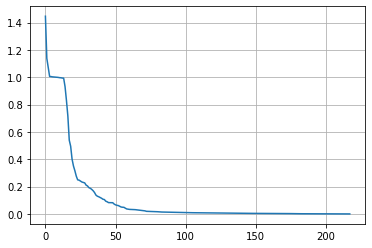

In [ ]:
#Scree Plot
plt.plot(pca.explained_variance_)
plt.grid()

From scree plot, it appears that about 50 features can be used while remaining can be eliminated as they have neglible explained varian-ce.

In [ ]:
pca = PCA(50)
X_after_PCA = pca.fit_transform(X_before_PCA)
Y = one_hot_encoded_scaled_new_data['target']
col_list = ['PCA'+str(i+1) for i in range(X_after_PCA.shape[1])]
X_after_PCA_df = pd.DataFrame(data = X_after_PCA, columns = col_list)

In [ ]:
X_after_PCA_df.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,PCA20,PCA21,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30,PCA31,PCA32,PCA33,PCA34,PCA35,PCA36,PCA37,PCA38,PCA39,PCA40,PCA41,PCA42,PCA43,PCA44,PCA45,PCA46,PCA47,PCA48,PCA49,PCA50
0,-0.521768,-0.215921,-0.255480,-2.000797,0.743685,-1.116277,-0.745647,-0.503097,0.064372,1.186750,0.637424,-2.053685,-0.432788,0.215405,-0.213809,0.836430,-1.277477,-0.810831,0.448183,-0.433523,0.654509,0.325430,0.665161,1.347109,-0.337229,-0.127827,-0.382118,0.246184,-0.413692,0.582830,-0.299976,0.044054,0.167998,-0.478832,0.021627,0.529082,-0.100737,0.841046,0.398039,0.609005,-0.430005,-0.124849,0.143372,0.104258,-0.775923,-0.146164,-0.095629,0.241232,-0.093388,0.784017
1,0.346883,0.320766,0.588772,1.370337,-1.502913,-0.720217,-0.818865,0.353036,-1.254466,0.499414,1.117033,0.025036,-0.242304,-0.277345,0.157853,-1.683007,0.828144,0.495865,0.441008,0.082399,0.139395,0.445430,-0.604718,0.441271,-0.422197,-0.163609,-0.415880,-0.685885,0.747964,0.284061,-0.287768,-0.573522,0.734924,-0.066700,0.332645,-0.503265,-0.529475,-0.133034,-0.143309,-0.460023,0.027825,-0.118311,-0.180535,0.135155,0.124844,-0.175219,-0.248435,-0.079928,0.278117,0.027659
2,-2.650671,0.884207,-0.554959,-1.452567,0.728907,1.045396,-1.110725,0.677063,-0.369662,0.728106,0.384975,-1.151071,1.522928,0.939434,0.307527,0.793801,-0.257717,0.231795,0.618528,-1.592040,-0.303414,-0.019162,0.746730,-0.157365,-0.455906,-0.000142,-0.386074,-0.007426,0.656251,-0.259472,-0.292300,0.121661,0.812720,0.374211,0.329454,-0.331707,0.082400,-0.154010,1.011736,-0.133582,-0.028622,-0.133166,-0.139495,0.094872,-0.004135,-0.023159,-0.192472,0.264498,-0.265862,-0.275775
3,0.785283,0.771321,-1.941439,-0.562083,-1.135919,1.876237,1.225148,0.021991,1.135451,0.743092,0.864023,-0.175003,1.999929,1.765408,0.791552,0.647648,1.092666,0.194879,-0.118060,0.607521,-0.505509,-0.515918,0.157860,-0.131136,0.513213,0.385266,0.646264,-0.482257,-0.293404,-0.141152,-0.281062,-0.051677,-0.557260,-0.514419,0.582496,0.889912,0.113032,-0.161465,0.133774,-0.091702,-0.046117,-0.137316,-0.374515,0.215400,0.118656,0.251166,-0.105485,0.958246,0.072660,0.000386
4,1.303377,-1.610359,-0.396237,0.073708,-0.340673,0.590989,1.278235,0.767840,-1.278234,-0.674850,-1.363533,1.132306,-0.475225,-0.941526,0.143932,1.156931,1.115027,0.174474,0.889861,0.278591,0.258918,0.517098,-0.255115,-0.007827,0.551710,0.272141,0.660401,0.534852,0.593046,0.108936,0.705962,0.352176,0.332896,-0.122521,0.200785,-0.437177,0.403572,-0.172114,0.776798,0.035897,-0.019668,-0.120172,0.079496,0.154133,0.192825,-0.177026,-0.349013,-0.085555,-0.496306,-0.278574


#### Train Test split of data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_after_PCA_df,Y,test_size=0.2,random_state=0)

In [ ]:
X_train

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,PCA20,PCA21,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30,PCA31,PCA32,PCA33,PCA34,PCA35,PCA36,PCA37,PCA38,PCA39,PCA40,PCA41,PCA42,PCA43,PCA44,PCA45,PCA46,PCA47,PCA48,PCA49,PCA50
24433,-0.045038,-0.945616,0.125102,0.153660,2.183332,-0.225910,0.549334,-1.058284,0.813205,0.819516,-1.005620,-1.057488,-0.462178,-0.298413,-0.405640,0.744182,0.256167,-1.227820,0.189939,0.035276,0.428113,-0.321695,-0.358493,0.850399,-0.391565,-0.994288,-0.460213,-0.556698,0.719750,0.309157,0.721111,0.256485,-0.258950,0.567310,-0.278826,0.413029,0.544683,-0.175401,-0.312196,0.365685,-0.283219,-0.129346,0.078531,-0.826891,0.184002,-0.350741,-0.325643,0.032587,-0.160058,-0.179543
227637,-0.036134,0.959201,-1.220301,-1.641359,-0.395826,0.996694,1.247528,0.807725,-0.373424,1.164667,1.881137,0.025720,1.500400,0.563832,0.619433,0.033431,0.106449,1.023333,-0.091258,-0.014360,-0.127724,0.289338,-0.934085,1.090643,-0.412739,0.127332,0.569776,-0.462002,-0.286995,-0.359594,-0.285616,0.272329,-0.033084,-0.515112,-0.239098,-0.224668,-0.232720,-0.157051,-0.007670,0.541194,-0.369174,-0.123045,-0.204985,-0.148459,-0.022613,-0.110416,0.154579,0.522826,-0.335743,-0.007526
245461,0.536606,-0.410875,0.297094,0.445992,1.329228,-0.384768,1.205440,-1.007663,-0.479135,0.091395,-0.117578,-1.567056,1.336916,0.046049,0.596672,-1.177101,-0.060605,0.420868,0.323063,-0.054430,0.437171,-0.049777,-0.408787,-0.739417,-0.480848,-0.600242,0.634246,0.283502,-0.399813,0.140990,0.723790,-0.787036,0.349368,-0.522631,-0.646218,-0.079061,-0.434873,-0.143810,-0.023747,0.164724,-0.169799,-0.114989,-0.066945,-0.089041,-0.040631,-0.067133,-0.456071,-0.260026,0.396937,-0.110898
325281,-0.552148,3.503310,-0.398003,-1.052014,-1.390867,-0.562581,0.645030,1.627354,1.059306,-0.576839,-0.965876,0.051239,-0.162623,0.609149,-1.455502,-0.643274,-0.707307,0.428785,0.639520,-1.739934,-1.347194,0.362029,0.633022,0.083589,-0.468381,0.419860,-0.399912,-0.502106,0.747951,-0.500852,-0.293653,0.154025,0.793468,0.139025,0.272787,-0.645674,0.227703,-0.151483,-0.379016,-0.562404,-0.010929,-0.127161,-0.338694,0.303376,0.061702,0.411965,0.285032,-0.345566,-0.274714,0.129103
378468,-1.539148,-0.127874,1.360532,-0.459878,2.368232,0.510103,1.850989,-1.032651,0.299605,1.113100,0.938368,0.636550,0.995270,1.134173,-0.684183,-0.522635,-1.471718,-0.785058,0.322835,1.012888,-0.339347,-0.759951,0.676663,-0.599152,0.525980,0.395238,-0.319308,0.039463,-0.346695,-0.345218,0.698330,0.127486,0.062446,-0.340418,-0.154308,-0.393287,0.558034,-0.145714,-0.257124,-0.061454,-0.134736,0.882244,0.095076,0.049900,-0.033270,0.101573,0.191961,-0.229167,0.522027,-0.138771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,0.714902,-0.977498,-0.137082,-0.316566,-0.298316,-0.342157,0.750762,-1.159247,0.976158,-0.960011,-0.237160,0.468168,0.284608,0.941841,0.376017,0.395289,1.506802,0.502753,0.132071,0.849939,-0.314877,0.376245,-0.514095,-0.724964,0.524394,-0.828775,-0.385673,-0.473427,0.713152,0.783800,-0.285028,-0.020078,-0.346978,0.305198,-0.102827,1.094743,0.014096,-0.167656,-0.216592,0.249000,1.036725,-0.126606,0.044444,-0.072159,-0.201128,0.368947,-0.278774,-0.210412,-0.196948,-0.119395
152315,-0.592464,-1.096769,0.016616,-0.691091,-0.548123,0.929837,0.016601,-0.037241,0.337349,-1.061923,-1.783353,-0.966220,0.611991,-1.282800,0.883570,0.239591,0.431978,-0.290983,0.271529,-0.916172,-0.322569,-0.634932,-0.167097,0.172885,0.515613,0.788659,0.635763,-0.608902,-0.254660,-0.473948,-0.289872,0.133213,-0.093091,-0.337483,0.074787,-0.200866,0.161422,-0.156331,-0.215732,-0.184498,-0.140568,-0.116801,-0.009756,0.060496,0.042589,-0.045723,0.245973,0.405091,-0.478809,-0.018798
117952,0.661024,-0.968631,-0.459122,1.687056,0.638766,0.437079,2.291022,-1.297030,-0.507690,-0.441300,-0.909166

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
Y_train_pred = log_reg.predict(X_train)
Y_test_pred = log_reg.predict(X_test)
print('Train accuracy score:',accuracy_score(Y_train, Y_train_pred))
print('Train F1 score:',f1_score(Y_train, Y_train_pred))
print('Test accuracy score:',accuracy_score(Y_test,Y_test_pred))
print('Test F1 score:',f1_score(Y_test,Y_test_pred))

Train accuracy score: 0.9634940535818165
Train F1 score: 0.0
Test accuracy score: 0.9637861949043622
Test F1 score: 0.0


We see that accuracy of logistic regression model is high. But still it's a bad model because the f1-score is 0, which means that the model is unable to classify the minority classes (target 1). Let us check the confusion matrix to see whether this is true.  

Text(0.5, 15.0, 'Predicted')

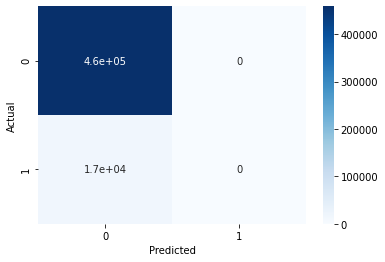

In [ ]:
sns.heatmap(confusion_matrix(Y_train,Y_train_pred),cmap='Blues',annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Text(0.5, 15.0, 'Predicted')

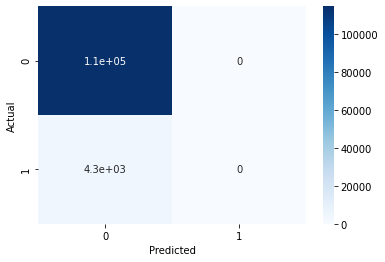

In [ ]:
sns.heatmap(confusion_matrix(Y_test,Y_test_pred),cmap='Blues',annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
print('Train precision score:',precision_score(Y_train, Y_train_pred))
print('Train recall score:',recall_score(Y_train,Y_train_pred))
print('Test precision score:',precision_score(Y_test,Y_test_pred))
print('Test recall score:',recall_score(Y_test,Y_test_pred))

Train precision score: 0.0
Train recall score: 0.0
Test precision score: 0.0
Test recall score: 0.0


**Inference:** So, one can infer this model cannot be used for production purposes, because it will fail to predict minority classes (target 1). We will try these three methods to improve the model.
* Using Weighted Cost Function.
* Using SMOTE to oversample minority classes.
* Oversampling minority classes and undersampling majority classes. 

#### Using Weighted Cost Function

In [ ]:
weighted_log_reg = LogisticRegression(class_weight='balanced') 
weighted_log_reg.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
Y_train_pred = weighted_log_reg.predict(X_train)
Y_test_pred = weighted_log_reg.predict(X_test)
print('Train accuracy score:',accuracy_score(Y_train, Y_train_pred))
print('Train F1 score:',f1_score(Y_train, Y_train_pred))
print('Test accuracy score:',accuracy_score(Y_test,Y_test_pred))
print('Test F1 score:',f1_score(Y_test,Y_test_pred))

Train accuracy score: 0.6170876306521424
Train F1 score: 0.09616766882630828
Test accuracy score: 0.6159286980334837
Test F1 score: 0.09353872995102996


Text(0.5, 15.0, 'Predicted')

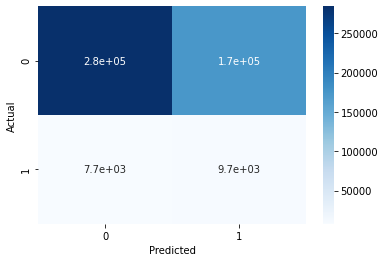

In [ ]:
sns.heatmap(confusion_matrix(Y_train,Y_train_pred),cmap='Blues',annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Text(0.5, 15.0, 'Predicted')

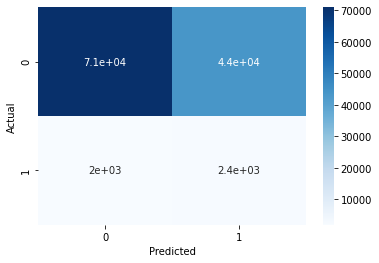

In [ ]:
sns.heatmap(confusion_matrix(Y_test,Y_test_pred),cmap='Blues',annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

We see that F1-score has improved to some extent although not much. Some target 1 data has been predicted correctly. Also, accuracy has taken a hit because significant target 0 data have been predicted incorrectly. This shows that there is some trade-off in accuracy and F1-score. We might need to explore improvements further.  

#### Using SMOTE to oversample minority classes.

In [ ]:
oversampler = SMOTE(sampling_strategy=0.2)
X, Y_oversampled = oversampler.fit_resample(X_after_PCA_df,Y)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y_oversampled,test_size=0.2,random_state=0)

In [ ]:
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
Y_train_pred = log_reg.predict(X_train)
Y_test_pred = log_reg.predict(X_test)
print('Train accuracy score:',accuracy_score(Y_train, Y_train_pred))
print('Train F1 score:',f1_score(Y_train, Y_train_pred))
print('Test accuracy score:',accuracy_score(Y_test,Y_test_pred))
print('Test F1 score:',f1_score(Y_test,Y_test_pred))

Train accuracy score: 0.5887979134579059
Train F1 score: 0.31738747648222304
Test accuracy score: 0.58802717134658
Test F1 score: 0.31439970982952486


Text(0.5, 15.0, 'Predicted')

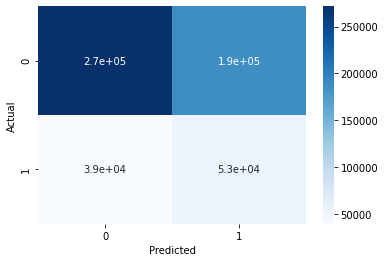

In [ ]:
sns.heatmap(confusion_matrix(Y_train,Y_train_pred),cmap='Blues',annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Text(0.5, 15.0, 'Predicted')

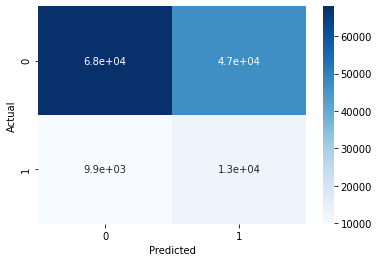

In [ ]:
sns.heatmap(confusion_matrix(Y_test,Y_test_pred),cmap='Blues',annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Oversampling using a sampling strategy of 0.2, ie: minority classes is 20% percent of the majority classes and using weighted cost function simultaneously has led to about 20% increase in the F1-score without any major dip in the accuracy part compared to previous model. 

#### Oversampling minority classes and undersampling majority classes

In [ ]:
oversampler = SMOTE(sampling_strategy=0.2)
undersampler = RandomUnderSampler(sampling_strategy=0.7)
X, Y_over_under = oversampler.fit_resample(X_after_PCA_df,Y)
X, Y_over_under = undersampler.fit_resample(X,Y_over_under)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y_over_under,test_size=0.2,random_state=0)

In [ ]:
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
Y_train_pred = log_reg.predict(X_train)
Y_test_pred = log_reg.predict(X_test)
print('Train accuracy score:',accuracy_score(Y_train, Y_train_pred))
print('Train F1 score:',f1_score(Y_train, Y_train_pred))
print('Test accuracy score:',accuracy_score(Y_test,Y_test_pred))
print('Test F1 score:',f1_score(Y_test,Y_test_pred))

Train accuracy score: 0.5827391396044891
Train F1 score: 0.5291821307233887
Test accuracy score: 0.5867571302927503
Test F1 score: 0.5323854981212552


Text(0.5, 15.0, 'Predicted')

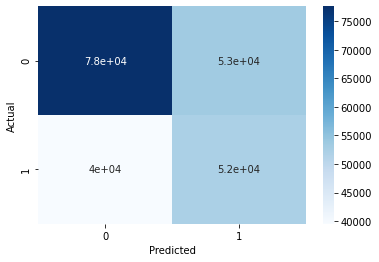

In [ ]:
sns.heatmap(confusion_matrix(Y_train,Y_train_pred),cmap='Blues',annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Text(0.5, 15.0, 'Predicted')

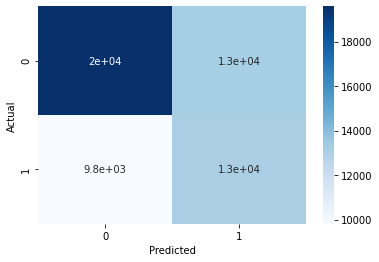

In [ ]:
sns.heatmap(confusion_matrix(Y_test,Y_test_pred),cmap='Blues',annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

So, F1 score has improved a lot here. With more tuning to find optimum sampling strategy, we can definitely achieve a model with more F1-score and accuracy. The F1 score has improved because we are removing the imbalance through data augumentation of minority class(target 1). So, the model is easily able to identify discernible patterns, which are available more due to large amount of such minority data, resulting in better segregation.

#### For model LinearSVC play with parameters dual,  max_iter and see if there is any improvement. SVC with  Imbalance Check & Feature Optimization & only 100K  Records is there improvement in scores? 

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_after_PCA_df,Y,test_size=0.2,random_state=0)

In [ ]:
lin_svc = LinearSVC()
lin_svc.fit(X_train, Y_train)

In [ ]:
Y_train_pred = lin_svc.predict(X_train)
Y_test_pred = lin_svc.predict(X_test)
print('Train accuracy score:',accuracy_score(Y_train,Y_train_pred))
print('Test accuracy score:',accuracy_score(Y_test,Y_test_pred))
print('Train F1-score:',f1_score(Y_train, Y_train_pred))
print('Test F1-score:',f1_score(Y_test,Y_test_pred))

LinearSVC without any parameter tuning performs very poorly. The F1-score is 0. Let us try to improve it using oversampling and undersampling just like we did in logistic regression. We will be taking only first 100k records and also do gridsearch for best paramters.  

In [ ]:
oversampler = SMOTE(sampling_strategy=0.3)
undersampler = RandomUnderSampler(sampling_strategy=0.5)
X,Y_over_under = oversampler.fit_resample(X_after_PCA_df,Y)
X,Y_over_under = undersampler.fit_resample(X,Y_over_under)

In [ ]:
X_first_100k = []
Y_first_100k = []
true_count = 50000
false_count = 50000
i = 0
while(true_count!=0 and false_count!=0):
      if Y_over_under[i] == 0:
         X_first_100k.append(list(X[i]))
         Y_first_100k.append(Y[i])
         i+=1
         false_count-=1
      if Y_over_under[i] == 1:
         X_first_100k.append(list(X[i]))
         Y_first_100k.append(Y[i])
         i+=1
         true_count-=1
X_first_100k = np.array(X_first_100k)
Y_first_100k = np.array(Y_first_100k)         

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_first_100k,Y_first_100k,test_size=0.2,random_state=0)

In [ ]:
#lin_svc = LinearSVC()
#param_grid = {'class_weight':[None,'balanced'],'dual':[True,False],'max_iter':[1000,5000]}
#lin_svc_gridsearch = GridSearchCV(lin_svc,param_grid,scoring='f1',n_jobs=-1)
#lin_svc_gridsearch.fit(X_train,Y_train)
#lin_svc_gridsearch.best_params_ = {'class_weight': 'balanced', 'dual': True, 'max_iter': 5000}

In [ ]:
lin_svc = LinearSVC(class_weight='balanced',dual=True,max_iter=5000)
lin_svc.fit(X_train, Y_train)
Y_train_pred = lin_svc.predict(X_train)
Y_test_pred = lin_svc.predict(X_test)
print('Train accuracy score:',accuracy_score(Y_train,Y_train_pred))
print('Test accuracy score:',accuracy_score(Y_test,Y_test_pred))
print('Train F1-score:',f1_score(Y_train, Y_train_pred))
print('Test F1-score:',f1_score(Y_test,Y_test_pred))

Using LinearSVC with feature optimization and 100k records led to only slight improvement in scores. But still the F1-score is very low because we have reduced the no. of records to 20% of the actual one. 

#### XGBoost is one of the better classifiers but still f1-score is very low. What could be the reason? 

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y_over_under,test_size=0.2,random_state=0)

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train,Y_train)

In [ ]:
Y_train_pred = xgb.predict(X_train)
Y_test_pred = xgb.predict(X_test)
print('Train accuracy score:',accuracy_score(Y_train,Y_train_pred))
print('Test accuracy score:',accuracy_score(Y_test,Y_test_pred))
print('Train F1-score:',f1_score(Y_train, Y_train_pred))
print('Test F1-score:',f1_score(Y_test,Y_test_pred))

In [ ]:
sns.heatmap(confusion_matrix(Y_train,Y_train_pred),cmap='Blues',annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
sns.heatmap(confusion_matrix(Y_test,Y_test_pred),cmap='Blues',annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
print('Train precision score:',precision_score(Y_train, Y_train_pred))
print('Train recall score:',recall_score(Y_train,Y_train_pred))
print('Test precision score:',precision_score(Y_test,Y_test_pred))
print('Test recall score:',recall_score(Y_test,Y_test_pred))

Through XGBoost, we are getting 0.78 as F1-score, which is definitely better than earlier classifier. But, still it's low. This is as observed above due to low recall score. 

In [ ]:
features_increase_count = len(one_hot_encoded_scaled_new_data.columns)-len(new_data.columns)
print('Increase in the number of features after one-hot encoding:',features_increase_count)

We have built model after one-hot encoding of data. So, we will built a logistic regression model for the data not having one-hot encoding and evaluate its performance with earlier ones.   

In [ ]:
#Using normal data without one-hot encoding
X = new_data.drop(['id','target'],axis=1)
sc = StandardScaler()
X[ordinal_var] = sc.fit_transform(X[ordinal_var])
pca = PCA()
X_label_encode_after_PCA  = pca.fit_transform(X)
Y = new_data['target']

In [ ]:
#PCA Dimensionality Reduction
n_components = 0
threshold = 95
variance_percent = 0
for i in pca.explained_variance_ratio_*100:
    if variance_percent>=95:
       break
    n_components+=1
    variance_percent+=i
pca = PCA(n_components)
X_label_encode_after_PCA  = pca.fit_transform(X)
Y = new_data['target']

In [ ]:
#Oversampling and Undersampling data
oversampler = SMOTE(sampling_strategy=0.3)
undersampler = RandomUnderSampler(sampling_strategy=0.5)
X_label_encode_after_PCA,Y_new = oversampler.fit_resample(X_label_encode_after_PCA,Y)
X_label_encode_after_PCA,Y_new = undersampler.fit_resample(X_label_encode_after_PCA,Y_new)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_label_encode_after_PCA,Y_new,test_size=0.2,random_state=0)

In [ ]:
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train,Y_train)
Y_train_pred = log_reg.predict(X_train)
Y_test_pred = log_reg.predict(X_test)
print('Train accuracy score:',accuracy_score(Y_train, Y_train_pred))
print('Train F1 score:',f1_score(Y_train, Y_train_pred))
print('Test accuracy score:',accuracy_score(Y_test,Y_test_pred))
print('Test F1 score:',f1_score(Y_test,Y_test_pred))

In [ ]:
print('Train precision score:',precision_score(Y_train, Y_train_pred))
print('Train recall score:',recall_score(Y_train,Y_train_pred))
print('Test precision score:',precision_score(Y_test,Y_test_pred))
print('Test recall score:',recall_score(Y_test,Y_test_pred))

So, it was observed that the model performs worse without one-hot encoding compared to one-hot encoding. Before one-hot encoding, the test F1-score of logistic regression is 0.42 but after one-hot encoding, the score is 0.53 i.e: about 11% increase in the F1-score.

XGBoost is the best model obtained so far if not missing a positive sample is a priority due to very high precision i.e: 99.95%, which means out of total predicted positives 99.95% is correct.

#### If not marking negative sample as positive is top priority, which model is best so far? 

A Simple Logistic Regression Model without oversampling and undersampling is the best model if not marking negative sample as positive is the priority. per class accuracy for target 0 is 100%, which 0% for target 1.

We will use AdaBoost model and evaluate its performance and compare it with the XGBoost. 

In [ ]:
oversampler = SMOTE(sampling_strategy=0.3)
undersampler = RandomUnderSampler(sampling_strategy=0.5)
X,Y_over_under = oversampler.fit_resample(X_after_PCA_df,Y)
X,Y_over_under = undersampler.fit_resample(X,Y_over_under)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y_over_under,test_size=0.2,random_state=0)

In [ ]:
ada_model = AdaBoostClassifier(random_state=0,n_estimators=100)
ada_model.fit(X_train, Y_train)

In [ ]:
Y_train_pred = ada_model.predict(X_train)
Y_test_pred = ada_model.predict(X_test)
print('Train accuracy score:',accuracy_score(Y_train, Y_train_pred))
print('Train F1 score:',f1_score(Y_train, Y_train_pred))
print('Test accuracy score:',accuracy_score(Y_test,Y_test_pred))
print('Test F1 score:',f1_score(Y_test,Y_test_pred))

In [ ]:
print('Train precision score:',precision_score(Y_train, Y_train_pred))
print('Train recall score:',recall_score(Y_train,Y_train_pred))
print('Test precision score:',precision_score(Y_test,Y_test_pred))
print('Test recall score:',recall_score(Y_test,Y_test_pred))

Precision-wise, XGBoost model is better than AdaBoost by about 2%. But, Recall-wise, the latter one is slightly better. Overall, XGBoost is better and faster than Adaboost.

#### MLPClassifier is the neural network we are trying. But how to choose the right no. of layers and size? At what layer size we get the best f1-score?

In [ ]:
param = {'hidden_layer_sizes':[(100,),(20,20,),(20,20,20,)],'random_state':[0]}
mlp_nn = MLPClassifier()
mlp_nn_gridsearch = GridSearchCV(mlp_nn,param_grid=param,n_jobs=-1,scoring='f1')
mlp_nn_gridsearch.fit(X_train,Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid

In [ ]:
print('Best Paramater for Multi-Layer Perceptron:',mlp_nn_gridsearch.best_params_)

Best Paramater for Multi-Layer Perceptron: {'hidden_layer_sizes': (100,), 'random_state': 0}


For hidden layer size of 100, we get the best F1-score. 

In [ ]:
mlp_nn = MLPClassifier(hidden_layer_sizes=(100,),random_state=0)
mlp_nn.fit(X_train,Y_train)
Y_train_pred = mlp_nn.predict(X_train)
Y_test_pred = mlp_nn.predict(X_test)
print('Train accuracy score:',accuracy_score(Y_train, Y_train_pred))
print('Train F1 score:',f1_score(Y_train, Y_train_pred))
print('Test accuracy score:',accuracy_score(Y_test,Y_test_pred))
print('Test F1 score:',f1_score(Y_test,Y_test_pred))

Train accuracy score: 0.9204735888717755
Train F1 score: 0.8726997848545345
Test accuracy score: 0.9125376575319908
Test F1 score: 0.860359733370451


So, MLP Classifier does have a good F1-score and accuracy score compared to AdaBoost Classifier and XGBoost Classifier ie: 9% more than AdaBoost and XGBoost and also very good accuracy score of more than 90%.